In [1]:
BLACKHOLE = False


import os
import sys
from pathlib import Path
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # fixes problem with graph


In [2]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.5.1+cu124
cuda


In [ ]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms
import numpy as np

hparams = hparams_nrms()

MAX_TITLE_LENGTH = 10
HISTORY_SIZE = 50
BATCH_SIZE = 64

word2vec_embedding = np.random.rand(1000, 100)

# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 16
hparams.head_dim = 16
hparams.attention_hidden_dim = 1000
hparams.linear_hidden_dim = 200

hparams.use_positional_encoding = False
hparams.use_learned_positions = False

# MODEL OPTIMIZER:
hparams.optimizer = "adam"
hparams.loss = "cross_entropy_loss"
hparams.dropout = 0.2
hparams.learning_rate = 1e-4

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding, debug=True)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(1000, 100)
    (dropout): Dropout(p=0.2, inplace=False)
    (self_attention): SelfAttention(
      (query_proj): Linear(in_features=100, out_features=256, bias=True)
      (key_proj): Linear(in_features=100, out_features=256, bias=True)
      (value_proj): Linear(in_features=100, out_features=256, bias=True)
    )
    (dense_layers): Sequential(
      (0): Linear(in_features=256, out_features=200, bias=True)
      (1): ReLU()
      (2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ReLU()
      (6): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=200, out_features=256, bias=True)
      (9): ReLU()
      (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (11): Dropout(p=0.2, inplace=False)
    )
    (att_la

In [5]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss() 
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [ ]:
# Train the model 
NPRATIO = 4

# Move model to GPU if available
model.to(device)

# Define the shapes of the input data
his_input_title_shape = (HISTORY_SIZE, MAX_TITLE_LENGTH)
pred_input_title_shape = (NPRATIO + 1, MAX_TITLE_LENGTH)
label_shape = (NPRATIO + 1,)
vocab_size = word2vec_embedding.shape[0]

# Generate some random input data for input_1 with values between 0 and 1
his_input_title = np.random.randint(0, vocab_size, (BATCH_SIZE, *his_input_title_shape))

# Generate some random input data for input_2 with values between 0 and 1
pred_input_title = np.random.randint(
    0, vocab_size, (BATCH_SIZE, *pred_input_title_shape)
)

# Generate some random label data with values between 0 and 1
label_data = np.zeros((BATCH_SIZE, *label_shape), dtype=int)
for row in label_data:
    row[np.random.choice(label_shape[0])] = 1

# Print the shapes of the input data to verify they match the model's input layers
print(his_input_title.shape) 
print(pred_input_title.shape)
print(label_data.shape)

# Convert the input data to PyTorch tensors
his_input_title = torch.from_numpy(his_input_title).long().to(device)
pred_input_title = torch.from_numpy(pred_input_title).long().to(device)
label_data = torch.from_numpy(label_data).long().to(device)

# Zero the gradients
optimizer.zero_grad()

# Forward pass
outputs = model(his_input_title, pred_input_title)

print(outputs.shape)
print(label_data.shape)

# Calculate the loss
loss = criterion(outputs, label_data)

# Backward pass
loss.backward()

# Update the weights
optimizer.step()

print("Done")



(64, 50, 10)
(64, 5, 10)
(64, 5)
torch.Size([64, 50])
torch.Size([64, 5])


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

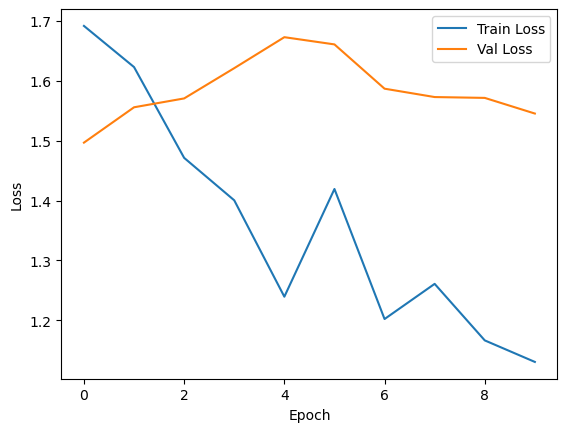

In [ ]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)

dataset.df_test

user_id,impression_id,impression_time,article_id_fixed,article_ids_clicked,article_ids_inview,labels
u32,u32,datetime[μs],list[i32],list[i32],list[i32],list[i8]
337540,384241557,2023-05-26 13:18:10,"[9776259, 9776087, … 9780039]",[9782421],"[9465878, 9782487, … 9778796]","[0, 0, … 0]"
2027502,337476478,2023-05-26 12:24:51,"[9775568, 9775809, … 9778902]",[9782290],"[9782057, 9782133, … 9782103]","[0, 0, … 0]"
1498918,488477676,2023-05-25 10:14:30,"[9775331, 9775256, … 9779577]",[9780496],"[9780547, 9780648, … 9780561]","[0, 0, … 0]"
2199061,312844535,2023-05-27 17:59:44,"[9772038, 9772088, … 9780039]",[9781998],"[9784444, 9417521, … 9784138]","[0, 0, … 0]"
1047938,112604512,2023-05-27 17:37:00,"[0, 0, … 9779813]",[9783850],"[9277736, 9784430, … 9779370]","[0, 0, … 0]"
…,…,…,…,…,…,…
750497,306815361,2023-05-27 16:22:16,"[9774020, 9774297, … 9779511]",[9783858],"[9615540, 9783075, … 9621194]","[0, 0, … 0]"
1674815,218662677,2023-05-28 05:40:18,"[0, 0, … 9779674]",[9782884],"[9783790, 9782884, … 9784803]","[0, 1, … 0]"
1153721,281369856,2023-05-31 19:20:54,"[9776341, 9774559, … 9779517]",[9790645],"[9790532, 9790682, … 9790645]","[0, 0, … 1]"


In [ ]:
test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False, # Is true in EBREC, but then it does not work
    batch_size=1,
)

for batch in tqdm(test_dataloader, desc="Test"):
        (inputs, labels) = batch


Test: 100%|██████████| 25/25 [00:00<00:00, 152.86it/s]

Batch 0 with batch_size: 1
his_input_title: (1, 50, 30) Value in first row: [[   262  16471  35992 ...     17  11269  81708]
 [  1575 126957  58483 ...  82739    261  72468]
 [ 60592  49049 149727 ...  22772    172  73896]
 ...
 [  1310   7400  38552 ...      1      1      1]
 [128354    990   1991 ...     11  52454  28302]
 [   357  26073 187073 ...  15198  33532   8520]]
pred_input_title: (1, 12, 30) Value in first row: [[  2206    449  14936  59040     90      9     66  53631     60  78552
     603    588   4475  12912     56      5  19507      7   2811  24314
     139  82739      7  17474     17 144282    203  11504    242     34]
 [  3311 102570  68315  62738     14    109   8599   1505    563  14936
    6259    109  76968      5   1111  33532 102570    171 142404    261
   69480     19      4    495    149    203  62614    254  92674  56233]
 [161436   4935      4  62172  73119   3196     60  59215     72    545
      17  97809     12  57687  14663   5761   1063 136709     67    

In [ ]:
# Evaluate the model
BATCH_SIZE_TEST = 1 # Currently onoy supports batch size 1

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=True, # Is true in EBREC, but then it does not work
    batch_size=BATCH_SIZE_TEST,
)

# go from [[a], [b], [c]] to [a, b, c]
def convert_to_list(l):
    return [(item) for sublist in l for item in sublist]
model.eval()

test_loss = 0.0
pred_test = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Test"):
        (inputs, labels) = batch
        print("Inputs")

        his_input_title, pred_input_title = inputs
        print(his_input_title[0])
        print(len(his_input_title[0]))
        print(his_input_title[0].shape)


        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        print("Output")
        print(outputs.tolist())
        print("Labels")
        print(labels.tolist())
        list = convert_to_list(outputs.tolist())
        print(list)
        print("")

        
        
        pred_test.append(list)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels = dataset.df_test["labels"].to_list(),
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()
test_loss /= len(test_dataloader)
print("Test loss:", test_loss)

Test:  12%|█▏        | 3/25 [00:00<00:00, 22.52it/s]

his_input_title: (10, 50, 30), values: [[[     0      0      0 ...      0      0      0]
  [     0      0      0 ...      0      0      0]
  [     0      0      0 ...      0      0      0]
  ...
  [  4804  14299     72 ... 242511     18     17]
  [   581  52305  19114 ... 113349   1205 158023]
  [   360  16741  17938 ... 140852    933 105367]]

 [[     0      0      0 ...      0      0      0]
  [     0      0      0 ...      0      0      0]
  [     0      0      0 ...      0      0      0]
  ...
  [  4804  14299     72 ... 242511     18     17]
  [   581  52305  19114 ... 113349   1205 158023]
  [   360  16741  17938 ... 140852    933 105367]]

 [[     0      0      0 ...      0      0      0]
  [     0      0      0 ...      0      0      0]
  [     0      0      0 ...      0      0      0]
  ...
  [  4804  14299     72 ... 242511     18     17]
  [   581  52305  19114 ... 113349   1205 158023]
  [   360  16741  17938 ... 140852    933 105367]]

 ...

 [[     0      0      0 ...    

Test:  40%|████      | 10/25 [00:00<00:00, 24.79it/s]

Output
[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Labels
[[0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

his_input_title: (12, 50, 30), values: [[[   357  36799     56 ...   1144   3263    100]
  [  2371  14299     72 ...     18  20704    820]
  [   357  36799     56 ...   1144   3263    100]
  ...
  [174090  15161  20363 ...      1      1      1]
  [  8301    332 136617 ...   1004    149  44075]
  [   345    555 105920 ...     12  82739  43144]]

 [[   357  36799     56 ...   1144   3263    100]
  [  2371  14299     72 ...     18  20704    820]
  [   357  36799     5

Test:  64%|██████▍   | 16/25 [00:00<00:00, 26.55it/s]

Output
[[1.0], [1.0], [1.0], [1.0], [1.0]]
Labels
[[0.0], [0.0], [0.0], [0.0], [1.0]]
[1.0, 1.0, 1.0, 1.0, 1.0]

his_input_title: (6, 50, 30), values: [[[  1910      9  33378 ...     33   3271  82729]
  [  1910      9  33378 ...     33   3271  82729]
  [105920   4922    170 ...  80050     18    341]
  ...
  [  1429  44177   8395 ...   1144     17  34592]
  [    87     82  33683 ...    294  33752 100306]
  [ 26076      9   1098 ...  57280     12   3810]]

 [[  1910      9  33378 ...     33   3271  82729]
  [  1910      9  33378 ...     33   3271  82729]
  [105920   4922    170 ...  80050     18    341]
  ...
  [  1429  44177   8395 ...   1144     17  34592]
  [    87     82  33683 ...    294  33752 100306]
  [ 26076      9   1098 ...  57280     12   3810]]

 [[  1910      9  33378 ...     33   3271  82729]
  [  1910      9  33378 ...     33   3271  82729]
  [105920   4922    170 ...  80050     18    341]
  ...
  [  1429  44177   8395 ...   1144     17  34592]
  [    87     82  33683 ...

Test:  88%|████████▊ | 22/25 [00:00<00:00, 23.53it/s]

his_input_title: (18, 50, 30), values: [[[15161  7370     7 ...  4172  1755  2663]
  [19528   555    60 ...     1     1     1]
  [  873  1042  3405 ... 99918    33     1]
  ...
  [  893 22666   261 ...   271 20807     6]
  [   87    22     6 ... 36137 52344 13282]
  [  262  6530  7223 ...    60    40  1144]]

 [[15161  7370     7 ...  4172  1755  2663]
  [19528   555    60 ...     1     1     1]
  [  873  1042  3405 ... 99918    33     1]
  ...
  [  893 22666   261 ...   271 20807     6]
  [   87    22     6 ... 36137 52344 13282]
  [  262  6530  7223 ...    60    40  1144]]

 [[15161  7370     7 ...  4172  1755  2663]
  [19528   555    60 ...     1     1     1]
  [  873  1042  3405 ... 99918    33     1]
  ...
  [  893 22666   261 ...   271 20807     6]
  [   87    22     6 ... 36137 52344 13282]
  [  262  6530  7223 ...    60    40  1144]]

 ...

 [[15161  7370     7 ...  4172  1755  2663]
  [19528   555    60 ...     1     1     1]
  [  873  1042  3405 ... 99918    33     1]
  ...
 

Test: 100%|██████████| 25/25 [00:01<00:00, 24.47it/s]


his_input_title: (16, 50, 30), values: [[[   357  53705  32089 ...  19656  11380   3405]
  [ 61201  45709  30426 ...     12     20  23757]
  [  1310     72  94396 ...  38486     17 164658]
  ...
  [  1575  82217   6079 ...      1      1      1]
  [ 51661   6815  22193 ...   1134  18381     86]
  [  9907  91464   1872 ... 100265     13   3787]]

 [[   357  53705  32089 ...  19656  11380   3405]
  [ 61201  45709  30426 ...     12     20  23757]
  [  1310     72  94396 ...  38486     17 164658]
  ...
  [  1575  82217   6079 ...      1      1      1]
  [ 51661   6815  22193 ...   1134  18381     86]
  [  9907  91464   1872 ... 100265     13   3787]]

 [[   357  53705  32089 ...  19656  11380   3405]
  [ 61201  45709  30426 ...     12     20  23757]
  [  1310     72  94396 ...  38486     17 164658]
  ...
  [  1575  82217   6079 ...      1      1      1]
  [ 51661   6815  22193 ...   1134  18381     86]
  [  9907  91464   1872 ... 100265     13   3787]]

 ...

 [[   357  53705  32089 ...  19

AUC: 100%|███████████████████████████████████| 25/25 [00:00<00:00, 12496.44it/s]

Test loss: 0.0


In [ ]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
1.000 vs 0.000
0.000 vs 0.000
0.000 vs 1.000

Article 1
0.010 vs 0.000
0.000 vs 0.000
0.000 vs 1.000
0.793 vs 0.000
0.000 vs 0.000
0.189 vs 0.000
0.007 vs 0.000
0.000 vs 0.000

Article 2
0.001 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.001 vs 0.000
0.000 vs 0.000
0.782 vs 0.000
0.217 vs 0.000
0.000 vs 0.000
0.000 vs 1.000
0.000 vs 0.000

Article 3
0.000 vs 1.000
0.000 vs 0.000
0.915 vs 0.000
0.000 vs 0.000
0.004 vs 0.000
0.001 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.080 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000

Article 4
0.037 vs 1.000
0.133 vs 0.000
0.002 vs 0.000
0.827 vs 0.000
0.000 vs 0.000
0.001 vs 0.000

Article 5
0.000 vs 0.000
1.000 vs 0.000
0.000 vs 0.000
0.000 vs 1.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000

Article 6
0.000 vs 0.000
0.000 vs 1.000
0.149 vs 0.000
0.000 vs 0.000
0.001 vs 0.000
0.749 vs 0.000
0.101 vs 0.000
0.000 vs 0.000

Article 

Confusion Matrix:
[[26222  2121]
 [ 2203   338]]


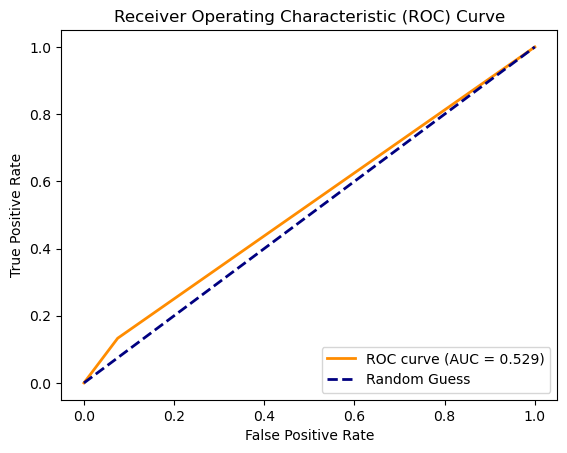

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Flatten the data for analysis
predicted_probabilities = [prob for article in pred_test for prob in article]
true_values = [val for article in labels[:len(pred_test)] for val in article]


# Set a threshold (commonly 0.5) to classify probabilities as 0 or 1
threshold = 0.5
predicted_classes = [1 if p >= threshold else 0 for p in predicted_probabilities]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC and ROC curve
fpr, tpr, thresholds = roc_curve(true_values, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value explicitly highlighted
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()